# ESSC4510/EASC5510 Statistical and Data Analysis for Earth System Science

## Chapter 7 The past influence the present

The following are the sample codes for the tutorial in the lecture and the book *Environmental Data Analysis with MATLAB*.

**ALL COPYRIGHT RESERVED**

Modified by Jw @2021-03

In [1]:
# eda07_00 clear all variables and import vatious modules
%reset -f
import os
from datetime import date
from math import exp, pi, sin, sqrt, floor, ceil
import numpy as np
import scipy.sparse.linalg as las
from scipy import sparse
import scipy.linalg as la
import scipy.signal as sg
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

# eda_draw function makes a "pictorial matrix equation"
# arguments are vectors, matrices and strings
# which are plotted in the order that the appear
# except that strings starting with 'title ' are plotted
# under the subseqeunt matrix or vector
# always returns a status of 1

def eda_draw(*argv):
    bw = np.zeros((256,4));
    v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
    bw[:,0] = v;
    bw[:,1] = v;
    bw[:,2] = v;
    bw[:,3] = np.ones(256);
    bwcmap = ListedColormap(bw);
    # size of plot
    W = 16;
    H = 4;
    fig1 = plt.figure(1);
    # figsize width and height in inches
    fig1.set_size_inches(W,H);
    ax1 = plt.subplot(1,1,1);
    plt.axis([0, W, -H/2, H/2]);
    plt.axis('off');
    LM = W/6;    # matrix width and heoght
    LV = W/40;   # vector width
    FS = 0.12;    # character width
    TO = 0.4;    # title vertical offset
    SP = 0.2;    # space between objects
    LS = 0.2;    # leading space
    p = LS; # starting x-position
    istitle=0; # flags presence of a title
    for a in argv:
        if isinstance(a,np.ndarray):
            sh = np.shape(a);
            if len(sh) == 1:  # conversion to nx1 array
                n = sh[0];
                m = 1;
                ap = a;
                a = np.zeros((n,1));
                a[:,0] = ap;
            else:
                n = sh[0];
                m = sh[1];
            if m==1:
                pold=p;
                left=p;
                right=p+LV;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LV;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
            else:
                pold=p;
                left=p;
                right=p+LM;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LM;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
        elif isinstance(a,str):
            ns = len(a);
            istitle=0;
            if( ns>=6 ):
                if 'title ' in a[0:6]:
                    istitle=1;
                    titlestr=a[6:];
            if( istitle != 1):
                plt.text(p,0,a);
                p = p + ns*FS + SP;
    plt.show();
    return 1;


def FTFmul(v):
    # this function is used by the bicongugate gradient solver to solve the geneneralized least
    # squares problem Fm=f.  Note that "F" must be called "edaFsparse".
    global edaFsparse;
    s = np.shape(v);
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    temp = edaFsparse*vv;
    return edaFsparse.transpose()*temp;


def GLSFilterMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where G is a topplitz matrix built from the filter g
    # Note that "H" must be sparese and called "edaHsparse" and that
    # the filter "g" bust be called edafilterg and must be a column vector
    global edaHsparse;
    global edafilterg;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    N, i = np.shape(edafilterg);
    # implements (GT G + HT H) v
    temp1 = np.zeros((N+M-1,1));
    temp1[:,0] = np.convolve(edafilterg.ravel(),vv.ravel()); # G v is of length N
    a = np.zeros((N,1));
    a[:,0] = temp1[0:N,0];
    b = edaHsparse * v; # H v is of length K
    temp2 = np.zeros((N+N-1,1));
    temp2[:,0] = np.convolve((np.flipud(edafilterg)).ravel(),a.ravel()); # GT (G v) is of length M
    a2 = temp2[N-1:N+M-1,0];
    b2 = edaHsparse.transpose()*b; # HT (H v) is of length M
    # FT F v = GT G v + HT H v
    return (a2+b2);


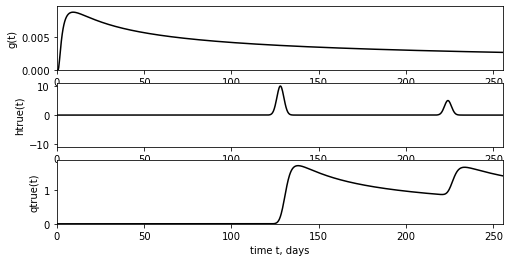

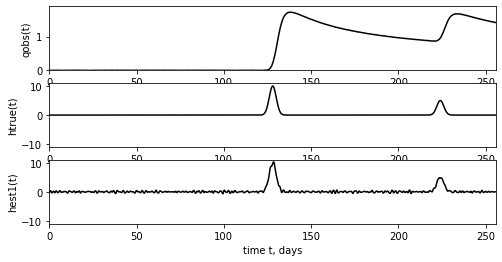

In [145]:
# eda07_01
# example of a filter problem
# using impulse repsonse of a heat-producing layer
# with solution by damped least squares
# Note: symbol q for theta, temperture

# time setup for g (length M)
M=1024;
N=M;
Dtdays = 0.5;
tdays = np.zeros((N,1));
tdays[:,0] = Dtdays*np.linspace(0,Dtdays*(N-1),N);
Dtseconds = Dtdays*3600*24;
tseconds = Dtseconds*tdays;

# materal constants
rho = 1500; # kg/m3
cp = 800; # J / kg-K
kappa = 1.25e-6; # m2/s
z = 1; # m

# impulse response
g = np.zeros((M,1));
g[0,0] = 0.0;
P1 = (1/(rho*cp));
P2 = (Dtseconds/sqrt(2*pi));
P3 = np.reciprocal( np.sqrt(2*kappa*tseconds[1:M]));
P4 = np.exp( -0.5*(z**2)*np.reciprocal(2*kappa*tseconds[1:M]));
g[1:M,0] = (P1 * P2 * np.multiply(P3 ,P4)).ravel();

#true heat production
t1 = Dtdays*N/4;
t2 = Dtdays*7*N/16;
sd = Dtdays*N/256;
Ah=10;
P5 = np.exp(-np.power(tdays-t1,2) / (2*sd**2) );
P6 = np.exp(-np.power(tdays-t2,2) / (2*sd**2) );
htrue = np.zeros((N,1));          
htrue[:,0] = (Ah*P5 + 0.5*Ah*P6).ravel();

# predict true temperature 
qtrue = np.zeros((N,1));
tmp = np.convolve(g.ravel(), htrue.ravel())
qtrue[0:N,0]=tmp[0:N];

# plot impulse response
fig1 = plt.figure(1,figsize=(8,4));
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[M-1,0], 0, 1.1*np.max(g)] );
plt.plot(tdays[0:M],g,'k-');
plt.xlabel('time t, days');
plt.ylabel('g(t)');

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:M],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot true temperature
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qtrue)] );
plt.plot(tdays[0:N],qtrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('qtrue(t)');
plt.show();

# matrix version of impulse response
Gcol = np.concatenate((g,np.zeros((N-M,1))),axis=0);
v = np.zeros((1,1));
v[0,0]=g[0,0];
Grow = np.concatenate((v,np.zeros((1,M-1))),axis=1);
G = la.toeplitz( Gcol, Grow );
qtrue2 = np.matmul(G,htrue);

# create simulated observations, qobs = qtrue+noise
sigmad=0.001*np.amax(qtrue);
qobs=qtrue+np.random.normal(0,sigmad,(N,1));

# plot simulated observations
fig2 = plt.figure(2,figsize=(8,4));
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qobs)] );
plt.plot(tdays[0:N],qobs,'k-');
plt.xlabel('time t, days');
plt.ylabel('qobs(t)');

# solve for h given qobs and g using least squares
GTG = np.matmul(G.T,G);
GTGmax = np.amax(GTG);
e2=1e-4*GTGmax;
hest1 = la.solve(GTG+e2*np.identity(M), np.matmul(G.T,qobs) );

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot estimated heat production
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],hest1,'k-');
plt.xlabel('time t, days');
plt.ylabel('hest1(t)');
plt.show();


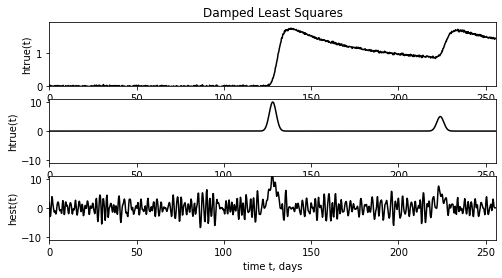

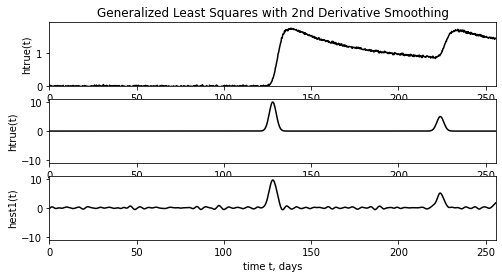

In [147]:
# eda07_02
# example of a filter problem
# using impulse repsonse of a heat-producing layer
# with solution via generalized least squares
# with the prior information of smoothness
# Note: symbol q for theta, temperture.
# This is the non-sparse implementation.

# time setup for g (length M)
M=1024;
N=M;
Dtdays = 0.5;
tdays = np.zeros((N,1));
tdays[:,0] = Dtdays*np.linspace(0,Dtdays*(N-1),N);
Dtseconds = Dtdays*3600*24;
tseconds = Dtseconds*tdays;

# materal constants
rho = 1500; # kg/m3
cp = 800; # J / kg-K
kappa = 1.25e-6; # m2/s
z = 1; # m

# impulse response
g = np.zeros((M,1));
g[0,0] = 0.0;
P1 = (1/(rho*cp));
P2 = (Dtseconds/sqrt(2*pi));
P3 = np.reciprocal( np.sqrt(2*kappa*tseconds[1:M]));
P4 = np.exp( -0.5*(z**2)*np.reciprocal(2*kappa*tseconds[1:M]));
g[1:M,0] = (P1 * P2 * np.multiply(P3 ,P4)).ravel();

#true heat production
t1 = Dtdays*N/4;
t2 = Dtdays*7*N/16;
sd = Dtdays*N/256;
Ah=10;
P5 = np.exp(-np.power(tdays-t1,2) / (2*sd**2) );
P6 = np.exp(-np.power(tdays-t2,2) / (2*sd**2) );
htrue = np.zeros((N,1));          
htrue[:,0] = (Ah*P5 + 0.5*Ah*P6).ravel();
# predict true temperature 
qtrue = np.zeros((N,1));
tmp = np.convolve(g.ravel(), htrue.ravel())
qtrue[0:N,0]=tmp[0:N];

# matrix version of impulse response
Gcol = np.concatenate((g,np.zeros((N-M,1))),axis=0);
v = np.zeros((1,1));
v[0,0]=g[0,0];
Grow = np.concatenate((v,np.zeros((1,M-1))),axis=1);
G = la.toeplitz( Gcol, Grow );
qtrue2 = np.matmul(G,htrue);

# create simulated observations, qobs = qtrue+noise
sigmad=0.01*np.amax(qtrue);
qobs=qtrue+np.random.normal(0,sigmad,(N,1));

# for comparison purposes, solve for h given qobs and g using least squares
GTG = np.matmul(G.T,G);
GTGmax = np.amax(GTG);
e2=1e-4*GTGmax;
hest2 = la.solve(GTG+e2*np.identity(M), np.matmul(G.T,qobs) );

# generalized leasr squares with F = [G; H]  and  f = [qobs, 0]
# second derivative smoothing in interior of interval; nothing on ends
e=10*np.amax(G);
Hcol = np.zeros((M-2,1));
Hcol[0,0] = e;
Hrow = np.zeros((1,M));
Hrow[0,0] = e;
Hrow[0,1] = -2*e;
Hrow[0,2] = e;
H = la.toeplitz( Hcol, Hrow );
h = np.zeros((M-2,1))
F = np.concatenate( (G,H), axis=0 );
f = np.concatenate( (qobs,h), axis=0 );
FTF = np.matmul(F.T,F);
hest3 = la.solve(FTF, np.matmul(F.T,f) );

# figure 1
fig1 = plt.figure(1,figsize=(8,4));

# plot observations
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qobs)] );
plt.plot(tdays[0:N],qobs,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');
plt.title('Damped Least Squares');

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot estimated heat production
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],hest2,'k-');
plt.xlabel('time t, days');
plt.ylabel('hest(t)');
plt.show();

# figure 2
fig2 = plt.figure(2,figsize=(8,4));

# plot observations
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qobs)] );
plt.plot(tdays[0:N],qobs,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');
plt.title('Generalized Least Squares with 2nd Derivative Smoothing');

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot estimated heat production
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],hest3,'k-');
plt.xlabel('time t, days');
plt.ylabel('hest1(t)');
plt.show();



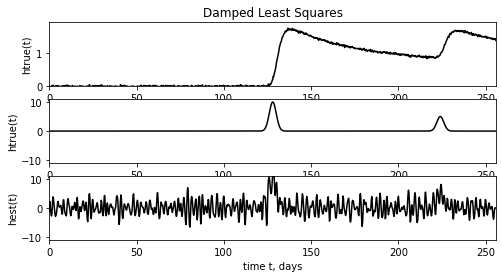

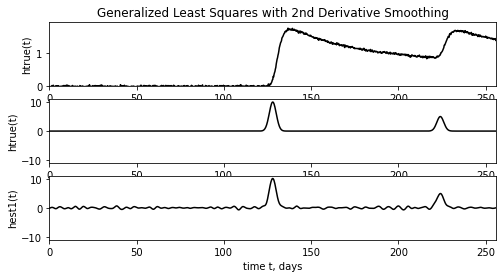

In [149]:
# eda07_03
# example of a filter problem
# using impulse repsonse of a heat-producing layer
# with solution via generalized least squares
# with the prior information of smoothness
# Note: symbol q for theta, temperture
# This is the sparse implementation.

# time setup for g (length M)
M=1024;
N=M;
Dtdays = 0.5;
tdays = np.zeros((N,1));
tdays[:,0] = Dtdays*np.linspace(0,Dtdays*(N-1),N);
Dtseconds = Dtdays*3600*24;
tseconds = Dtseconds*tdays;

# materal constants
rho = 1500; # kg/m3
cp = 800; # J / kg-K
kappa = 1.25e-6; # m2/s
z = 1; # m

# impulse response
g = np.zeros((M,1));
g[0,0] = 0.0;
P1 = (1/(rho*cp));
P2 = (Dtseconds/sqrt(2*pi));
P3 = np.reciprocal( np.sqrt(2*kappa*tseconds[1:M]));
P4 = np.exp( -0.5*(z**2)*np.reciprocal(2*kappa*tseconds[1:M]));
g[1:M,0] = (P1 * P2 * np.multiply(P3 ,P4)).ravel();
edafilterg = g;

#true heat production
t1 = Dtdays*N/4;
t2 = Dtdays*7*N/16;
sd = Dtdays*N/256;
Ah=10;
P5 = np.exp(-np.power(tdays-t1,2) / (2*sd**2) );
P6 = np.exp(-np.power(tdays-t2,2) / (2*sd**2) );
htrue = np.zeros((N,1));          
htrue[:,0] = (Ah*P5 + 0.5*Ah*P6).ravel();

# predict true temperature 
qtrue = np.zeros((N,1));
tmp = np.convolve(g.ravel(), htrue.ravel())
qtrue[0:N,0]=tmp[0:N];

# create simulated observations, qobs = qtrue+noise
sigmad=0.01*np.amax(qtrue);
qobs=qtrue+np.random.normal(0,sigmad,(N,1));

# for comparison purposes, solve for h given qobs and g using least squares
Gcol = np.concatenate((g,np.zeros((N-M,1))),axis=0);
v = np.zeros((1,1));
v[0,0]=g[0,0];
Grow = np.concatenate((v,np.zeros((1,M-1))),axis=1);
G = la.toeplitz( Gcol, Grow );
qtrue2 = np.matmul(G,htrue);
GTG = np.matmul(G.T,G);
GTGmax = np.amax(GTG);
e2=1e-4*GTGmax;
hest2 = la.solve(GTG+e2*np.identity(M), np.matmul(G.T,qobs) );

# generalized leasr squares with F = [G; H]  and  f = [qobs, 0]
# second derivative smoothing in interior of interval; nothing on ends
e=10*np.amax(G);
edaHsparse = sparse.diags([e, -2*e, e], [0, 1, 2], shape=(M-2, M));
h = np.zeros((M-2,1));

# set up right hand side, F'f = GT qobs + HT h
temp = np.zeros((N+M-1,1));
temp[:,0] = np.convolve(np.flipud(edafilterg).ravel(),qobs.ravel());
FTfa = np.zeros((M,1));
FTfa[:,0] = temp[N-1:N+M-1,0];
FTfb = edaHsparse.transpose()*h;
FTf=FTfa+FTfb;

# define linear operator needed for conjugate gradienet solver
LO=las.LinearOperator(shape=(M,M),matvec=GLSFilterMul,rmatvec=GLSFilterMul);

# solve for estimated model parameters using congugate gradient algrorithm
hest3 = np.zeros((M,1));
q=las.cg(LO,FTf,tol=1e-6, maxiter=(3*(N+M)+100));
hest3[:,0] = q[0];

# figure 1
fig1 = plt.figure(1,figsize=(8,4));

# plot observations
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qobs)] );
plt.plot(tdays[0:N],qobs,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');
plt.title('Damped Least Squares');

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot estimated heat production
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],hest2,'k-');
plt.xlabel('time t, days');
plt.ylabel('hest(t)');
plt.show();

# figure 2
fig2 = plt.figure(2,figsize=(8,4));

# plot observations
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qobs)] );
plt.plot(tdays[0:N],qobs,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');
plt.title('Generalized Least Squares with 2nd Derivative Smoothing');

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot estimated heat production
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],hest3,'k-');
plt.xlabel('time t, days');
plt.ylabel('hest1(t)');
plt.show();

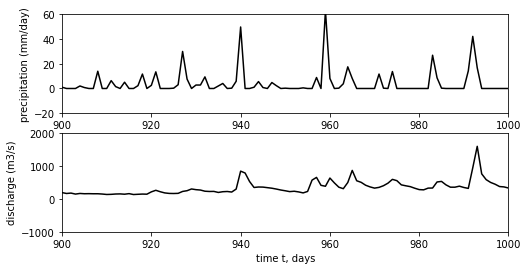

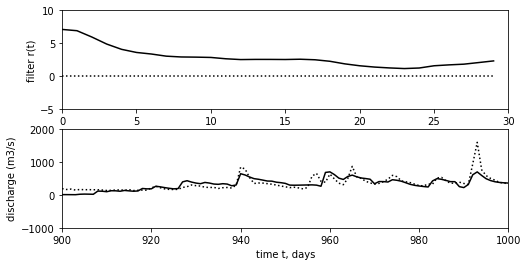

In [151]:
# eda07_04
# example of estimating a filter r that predicts river
# discharge d from precipitation data g; that is, g*r=d

# in this example, the filter length is chosen to be
# M<<N, to embody the idea that the response of the river
# (meaning the length M of the filter r) is short

M=30; # length of filter r

# load merged discharge and precipitation data
# column 1: time in inter count of days starting 1/1/2002
# column 2: Hudson River discharge in cfs
# column 3: Albany NY precipitation in inches
D = np.genfromtxt('precip_discharge_data.txt', delimiter='\t')
[Nlong, K]=D.shape;
tlong = np.zeros((Nlong,1)); 
tlong[:,0] = D[:,0]; # time in days
dlong = np.zeros((Nlong,1));
dlong[:,0] = D[:,1]/35.3146; # discharge in cubic meters per second
glong = np.zeros((Nlong,1)); # precipitation in millimeters per day
glong[:,0] = D[:,2]*25.4;
Dt = tlong[1,0]-tlong[0,0];

# in this example, we use only a 101 day portion of the
# dataset, mainly so that when we plot it, storm events
# are clearly visible

N=101;
istart = 900-1;
t = np.zeros((N,1)); 
t[:,0] = tlong[istart:istart+N,0];
d = np.zeros((N,1));
d[:,0] = dlong[istart:istart+N,0];
g = np.zeros((N,1));
g[:,0] = glong[istart:istart+N,0];
tmin = t[0,0];
tmax = t[N-1,0];
edafilterg = g;

# figure 1: discharge and precipitation data
fig1 = plt.figure(1,figsize=(8,4));

# plot observations
ax1 = plt.subplot(2,1,1);
plt.axis([tmin, tmax, -20, 60 ] );
plt.plot(t,g,'k-');
plt.xlabel('time t, days');
plt.ylabel('precipitation (mm/day)');

ax1 = plt.subplot(2,1,2);
plt.axis([tmin, tmax, -1000, 2000 ] );
plt.plot(t,d,'k-');
plt.xlabel('time t, days');
plt.ylabel('discharge (m3/s)');
plt.show();

# Given the filter equation g*r=d, solve for r given d and g
# using genralized least squares

# Note that the convolution relationship g*r=d is equivalent
# to the matrix equation G r = d where G is the (g*) operator,
# Since we are using filterfun(), we do not need to construct
# G.  We do, however, need to implement the prior information
# equation Hr=h.

# This code can toggle between the prior information of r
# being small, its first derivative being small and its second
# derivative being small, depending on whether DERIVATIVE is 0,
# 1 or 2. (However, the results turn out not to be especially
# sensitive to the choice).
DERIVATIVE=1;
if( DERIVATIVE==2 ):
    # The prior information equation H*r = h is implemented
    # for the smoothness condition of the second derivative
    # being close to zero
    e=2*np.amax(g); # the coefficient was manually tuned
                    # to produce a reasonably smooth filter
    K=M;
    L=N+K;
    # second derivative operator; no end conditions
    edaHsparse = sparse.diags([e, -2*e, e], [0, 1, 2], shape=(M-2, M));
    h = np.zeros((M-2,1));
elif (DERIVATIVE==1):
    # The prior information equation H*r = h is implemented
    # for the smoothness condition of the first derivative
    # being close to zero
    e=4.0*np.amax(g); # the coefficient was manually tuned
                      # % to produce a reasonably smooth filter
    edaHsparse = sparse.diags([-e, e], [0, 1], shape=(M-1, M));
    h = np.zeros((M-1,1));
else: # DERRIVATIVE == 0
    # The prior information equation H*r = h is implemented
    # for the smallness condition of the filter is close to zero
    e=0.1*max(abs(g)); # the coefficient was manually tuned
                       # to produce a reasonably small filter
    edaHsparse = sparse.diags([e], [0], shape=(M, M));
    h = np.zeros((M,1));
    
# set up right hand side, F'f = GT qobs + HT h
temp = np.zeros((N+N-1,1));
temp[:,0] = np.convolve(np.flipud(edafilterg).ravel(),d.ravel());
FTfa = np.zeros((M,1));
FTfa[:,0] = temp[N-1:N+M-1,0];
FTfb = edaHsparse.transpose()*h;
FTf=FTfa+FTfb;

# define linear operator needed for conjugate gradienet solver
LO=las.LinearOperator(shape=(M,M),matvec=GLSFilterMul,rmatvec=GLSFilterMul);

# solve for estimated model parameters using congugate gradient algrorithm
r = np.zeros((M,1));
q=las.cg(LO,FTf,tol=1e-6, maxiter=(3*(N+M)+100));
r[:,0] = q[0];

# filter time axis
tr = np.zeros((M,1));
tr[:,0] = Dt*np.linspace(0,M-1,M);

# predicted discharge
temp = np.convolve(g.ravel(),r.ravel());
dpre = np.zeros((N,1));
dpre = temp[0:N];

# figure 2: filter and predicted discharge 
fig2 = plt.figure(2,figsize=(8,4));

# plot observations
ax1 = plt.subplot(2,1,1);
plt.axis([0, M, -5, 10 ] );
plt.plot(tr,r,'k-');
plt.plot([tr[0,0], tr[M-1,0]],[0,0],'k:');
plt.xlabel('time t, days');
plt.ylabel('filter r(t)');

ax1 = plt.subplot(2,1,2);
plt.axis([tmin, tmax, -1000, 2000 ] );
plt.plot(t,d,'k:');
plt.plot(t,dpre,'k-');
plt.xlabel('time t, days');
plt.ylabel('discharge (m3/s)');
plt.show();


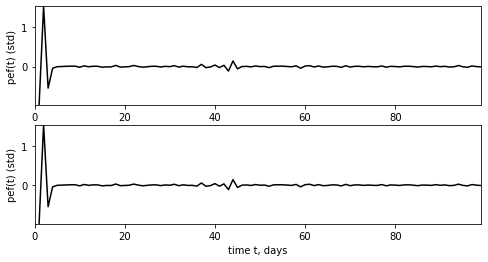

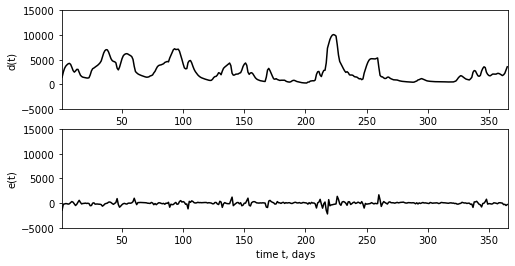

In [153]:
# eda07_05
# prediction error filter (pef) for Neuse Rievr Hydrograph
# this code uses generalized least squares to implement
# the prior information that pef(1)=(-1).  Two solutions
# are calculated, one via standard matrix algebra,
# (FTF)\(FTf) and the other via the biconjugate gradient method

# read in data
D = np.genfromtxt('neuse.txt', delimiter='\t')
[N, K]=D.shape;
t = np.zeros((N,1)); 
t[:,0] = D[:,0]; # time in days
d = np.zeros((N,1));
d[:,0] = D[:,1]; # discharge in cubic meters per second
Dt = t[1,0]-t[0,0];
tmin = t[0,0];
tmax = t[N-1,0];

# sizes of various arrays
M=100; # length of pef is user tunable
K=1;
L=N+K;

# for a prediction error filter, pef, the data is the filter, g
g = d;
edafilterg = d;

# prior information that first element of the pef is (-1)
e=(10^1)*np.amax(g); # large weight
H=np.zeros((K,M));
H[0,0]=e;
h=np.zeros((1,1));
h[0,0]=(-e);

# Data Kernel (needed only for standard matrix algebra calculation
v = np.zeros((1,1));
v[0,0]=g[0,0];
Grow = np.concatenate((v,np.zeros((1,M-1))),axis=1);
G = la.toeplitz( g, Grow );
# for pef, Gm=0

# F needed only for standard matrix algebra calculation
F = np.concatenate( (G, H), axis=0 );
rhs = np.zeros((N,1));
f = np.concatenate( (rhs, h), axis=0 );

# standard GLS solution
FTF = np.matmul( F.T, F );
FTf = np.matmul( F.T, f );
pef1 = la.solve(FTF, FTf );        

# now set up for biconjugate gradient method

# Hm=h
e=(10^1)*np.amax(g); # large weight
edaHsparse = sparse.diags([e], [0], shape=(1, M));
h=np.zeros((1,1));
h[0,0]=(-e);

# FT f can be done analytucally:
# FTf = GT 0 + HT h = 0 + [e 0 0 ... 0]T [-e] = [-e^2 0 0 ... 0]T
FTf = np.zeros((M,1));
FTf[0,0] = -(e**2);
           
# define linear operator needed for conjugate gradienet solver
LO=las.LinearOperator(shape=(M,M),matvec=GLSFilterMul,rmatvec=GLSFilterMul);

# solve for estimated model parameters using congugate gradient algrorithm
r = np.zeros((M,1));
q=las.cg(LO,FTf,tol=1e-6, maxiter=(3*(N+M)+100));
pef2 = np.zeros((M,1));
pef2[:,0] = q[0];

# prediction error
temp = np.convolve(pef2.ravel(),g.ravel());
perror = np.zeros((N,1));
perror[:,0] = temp[0:N]
           
# short time axis
tpef = np.zeros((M,1));    
tpef[:,0] = t[0:M,0];
           
# plot pef
fig1 = plt.figure(1,figsize=(8,4));

# plot prediction error filters
ax1 = plt.subplot(2,1,1);
plt.axis([ 0, Dt*(M-1), np.min(pef1), np.max(pef1)] );
plt.plot(tpef,pef1,'k-');
plt.xlabel('time t, days');
plt.ylabel('pef(t) (std)');

ax1 = plt.subplot(2,1,2);
plt.axis([ 0, Dt*(M-1), np.min(pef1), np.max(pef1)] );
plt.plot(tpef,pef2,'k-');
plt.xlabel('time t, days');
plt.ylabel('pef(t) (std)');
plt.show();

# plot hydrograph data and prediction error for first year
fig2 = plt.figure(2,figsize=(8,4));

Np = 365;
ax1 = plt.subplot(2,1,1);
plt.axis([tmin, tmin+Dt*Np, -5000, 15000]);
plt.plot(t[0:Np,0],d[0:Np,0],'k-');
plt.xlabel('time t, days');
plt.ylabel('d(t)');

ax1 = plt.subplot(2,1,2);
plt.axis([tmin, tmin+Dt*Np, -5000, 15000]);
plt.plot(t[0:Np,0],perror[0:Np,0],'k-');
plt.xlabel('time t, days');
plt.ylabel('e(t)');
plt.show();        
           

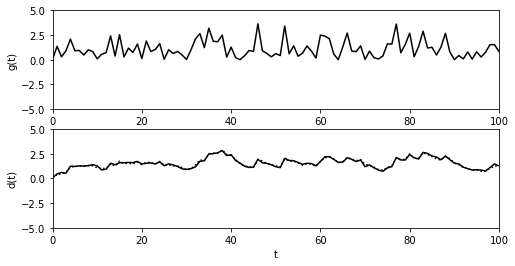

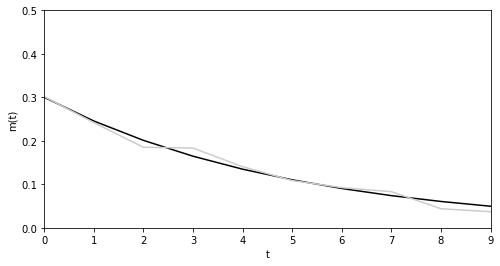

In [155]:
# eda07_06 Script supporting CribSheet 7.2
# Least squares filter estimation of filter m
# obeying g*m=d

# definition of time
N=101;
Dt = 1;
t = np.zeros((N,1));
t[:,0] = Dt*np.linspace(0,N-1,N);
tmin = t[0,0];
tmax = t[N-1,0];

# make some synthetic timeseries g
# draw from an exponential distribution so its all positive
g = np.random.exponential(1,(N,1));
edafilterg = g;

# exemplary true filter is decaying exponential
M=10;
c=5*Dt;
mtrue = np.zeros((M,1));
mtrue[:,0] = 0.3*np.exp(-t[0:M,0]/c);

# the true data is g covolved with m
temp = np.convolve(g.ravel(),mtrue.ravel());
dtrue = np.zeros((N,1));
dtrue[:,0] = temp[0:N];

# the observed data is the true data plus noise
# the noise is Normally distributed with zero mean and variance sigmad^2
sigmad = 0.1;
noise = np.random.normal(0,sigmad,(N,1));
d = dtrue + noise;

# now invert for the filter using the observed data and the time series g

# prior infoirmation of smoothness, with no end conditions
epsilon = 0.001;
e = epsilon/(Dt**2);
edaHsparse = sparse.diags([e, -2*e, e], [0, 1, 2], shape=(M-2, M));
h = np.zeros((M-2,1));

# set up right hand side, F'f = GT qobs + HT h
temp = np.zeros((N+N-1,1));
temp[:,0] = np.convolve(np.flipud(edafilterg).ravel(),d.ravel());
FTfa = np.zeros((M,1));
FTfa[:,0] = temp[N-1:N+M-1,0];
FTfb = edaHsparse.transpose()*h;
FTf=FTfa+FTfb;

# define linear operator needed for conjugate gradienet solver
LO=las.LinearOperator(shape=(M,M),matvec=GLSFilterMul,rmatvec=GLSFilterMul);

# solve for estimated model parameters using congugate gradient algrorithm
q=las.cg(LO,FTf,tol=1e-6, maxiter=(3*(N+M)+100));
mest = np.zeros((M,1));
mest[:,0] = q[0];

# predicted data
temp = np.convolve(g.ravel(),mest.ravel());
dpre = np.zeros((N,1));
dpre[:,0] = temp[0:N];

# compute the error
e = d-dpre;
E = np.matmul(e.T, e);

# Figure 1
fig1 = plt.figure(1,figsize=(8,4));

ax1 = plt.subplot(2,1,1);
plt.axis([tmin, tmax, -5, 5] );
plt.plot(t,g,'k-');
plt.xlabel('t');
plt.ylabel('g(t)');

ax1 = plt.subplot(2,1,2);
plt.axis([tmin, tmax, -5, 5] );
plt.plot(t,d,'k-');
plt.plot(t,dpre,'k:');
plt.xlabel('t');
plt.ylabel('d(t)');
plt.show();

# Figure 2
fig1 = plt.figure(1,figsize=(8,4));

ax1 = plt.subplot(1,1,1);
plt.axis([t[0,0], t[M-1,0], 0, 0.5] );
plt.plot( t[0:M], mtrue.ravel(),'k-');
plt.plot( t[0:M], mest.ravel(), 'k-', color = (0.8,0.8,0.8));
plt.xlabel('t');
plt.ylabel('m(t)');
plt.show();


0 roots not outside the unit circle
error of filter rebuilt from its roots: 0.000000
error of inverse filter: 0.000000


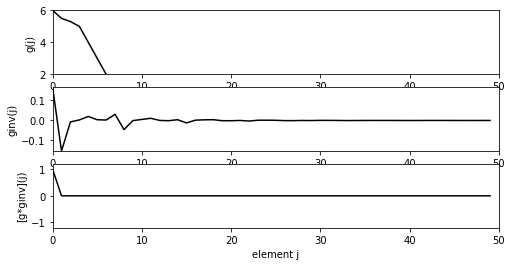

In [157]:
# eda07_07
# use z-transforms to:
#    check if a filter is minumum phase
#    represent it as a cascade of length-2 filters
#    compute the inverse filter

# define a filter
gf = [6, 5.5, 5.3, 5, 4, 3, 2];
N = len(gf);
g = np.zeros((N,1));
g[:,0] = gf;
gN = g[N-1,0];

# find roots of g
pol = (np.flipud(g)).ravel();
r = np.roots(pol);

# check size of roots
badroots=0;
for j in range(N-1):
    if( abs(r[j]) <= 1 ):
        badroots=badroots+1;

printstr = "%d roots not outside the unit circle" % (badroots);
print(printstr);

# rebuild filter from its roots
gp = np.zeros((1,1), dtype=np.complex);
gp[0,0]=gN;
for j in range(N-1):
    temp = np.convolve(gp.ravel(),[-r[j],1]);
    K = len(temp);
    gp = np.zeros((K,1), dtype=np.complex);
    gp[:,0] = temp;
    
# there should be no imiginary part
gp = np.real(gp);

# check that it worked
E1 = np.matmul( (g-gp).T , (g-gp) );
printstr = "error of filter rebuilt from its roots: %f" % (E1);
print(printstr);

# construct inverse filter, gi, of length Ni
Ni = 50;
gi = np.zeros((Ni,1),dtype=np.complex);
gi[0,0]=1/gN;
# filter cascade, one filter per loop
for j in range(N-1):
    # construct inverse filter of a length-2 filter
    temp = np.zeros((Ni,1),dtype=np.complex);
    temp[0,0] = 1;
    for k  in range(1,Ni):
        temp[k]=temp[k-1]/r[j];
    temp = -temp/r[j];
    temp2 = np.convolve(gi.ravel(),temp.ravel());
    gi[0:Ni,0]=temp2[0:Ni];

# delete imaginary part (which should be zero)
gi = np.real(gi);

# test quality of inverse filter
temp=np.convolve(g.ravel(),gi.ravel());
gig = np.zeros((Ni,1));
gig[:,0] = temp[0:Ni];

# impulse function
d = np.zeros((Ni,1));
d[0]=1;
E2 = np.matmul( (gig-d).T, (gig-d) );
printstr = "error of inverse filter: %f" % (E2);
print(printstr);

# plot results
fig1 = plt.figure(1,figsize=(8,4));

# plot filter
ax1 = plt.subplot(3,1,1);
plt.axis([0, Ni, np.min(g), np.max(g)] );
gx = np.concatenate( (g, np.zeros((Ni-N,1))), axis=0);
plt.plot( np.linspace(0,Ni-1,Ni), gx.ravel(),'k-');
plt.xlabel('element j');
plt.ylabel('g(j)');

ax1 = plt.subplot(3,1,2);
plt.axis([0, Ni, np.min(gi), np.max(gi)] );
plt.plot( np.linspace(0,Ni-1,Ni), gi.ravel(),'k-');
plt.xlabel('element j');
plt.ylabel('ginv(j)');

ax1 = plt.subplot(3,1,3);
plt.axis([0, Ni, -1.2, 1.2] );
plt.plot( np.linspace(0,Ni-1,Ni), gig.ravel(),'k-');
plt.xlabel('element j');
plt.ylabel('[g*ginv](j)');


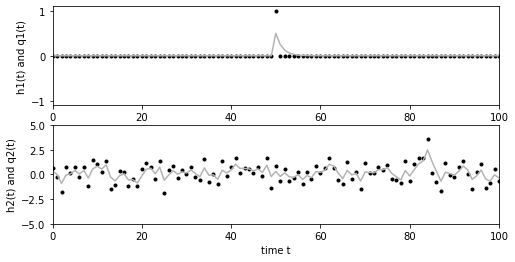

sum of elements of the unit spike: 1.000000
sum of elements of the filtered spike: 1.000000


In [159]:
# eda07_08
# example of recursive smoothing filter
# this version used for loops

# create two synthetic datasets
# h1, a unit spike
# h2, random noise with zero mean and unit variance
N=101;
Dt=1;
t = np.zeros((N,1));
t[:,0] =Dt*np.linspace(0,N-1,N);
h1=np.zeros((N,1));
No2 = floor(N/2);
h1[No2,0]=1;
h2=np.random.normal(0,1,(N,1));

# apply recursive filter
q1=np.zeros((N,1));
q1[0,0]=0.5*h1[0,0];
q2=np.zeros((N,1));
q2[0,0]=0.5*h2[0,0];
for j in range(2,N):
    q1[j,0]=0.5*(h1[j,0]+q1[j-1,0]);
    q2[j,0]=0.5*(h2[j,0]+q2[j-1,0]);
    
# plot results
fig1 = plt.figure(1,figsize=(8,4));

ax1 = plt.subplot(2,1,1);
plt.axis( [t[0,0], t[N-1,0], -1.1, 1.1] );
plt.plot( t, h1, 'k.');
plt.plot( t, q1, 'k-', color=(0.7,0.7,0.7));
plt.xlabel('time t');
plt.ylabel('h1(t) and q1(t)');

ax1 = plt.subplot(2,1,2);
plt.axis([t[0,0], t[N-1,0], -5, 5]);
plt.plot( t, h2, 'k.');
plt.plot( t, q2, 'k-', color=(0.7,0.7,0.7));
plt.xlabel('time t');
plt.ylabel('h2(t) and q2(t)');
plt.show();

displaystr = "sum of elements of the unit spike: %f" % (np.sum(h1));
print(displaystr);
displaystr = "sum of elements of the filtered spike: %f" % (np.sum(q1));
print(displaystr);

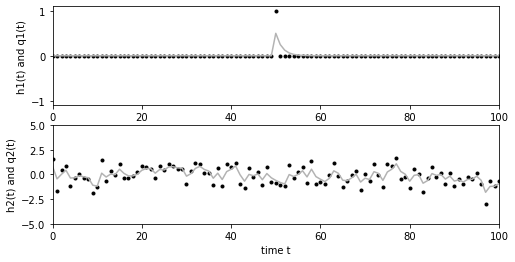

sum of elements of the unit spike: 1.000000
sum of elements of the filtered spike: 1.000000


In [162]:
# eda07_09
# example of recursive smoothing filter
# this version used scipy.signal.lfilter()

# create two synthetic datasets
# h1, a unit spike
# h2, random noise with zero mean and unit variance
N=101;
Dt=1;
t = np.zeros((N,1));
t[:,0] =Dt*np.linspace(0,N-1,N);
h1=np.zeros((N,1));
No2 = floor(N/2);
h1[No2,0]=1;
h2=np.random.normal(0,1,(N,1));

Nu = 2;
u = np.zeros((Nu,1));
u[:,0] = [0.5, 0.0];

Nv = 2;
v = np.zeros((Nv,1));
v[:,0] = [1.0, -0.5];

temp1 = sg.lfilter(u.ravel(),v.ravel(),h1.ravel());
q1 = np.zeros((N,1));
q1[:,0] = temp1[0:N];

temp2 = sg.lfilter(u.ravel(),v.ravel(),h2.ravel());
q2 = np.zeros((N,1));
q2[:,0] = temp2[0:N];

# plot results
fig1 = plt.figure(1,figsize=(8,4));

ax1 = plt.subplot(2,1,1);
plt.axis( [t[0,0], t[N-1,0], -1.1, 1.1] );
plt.plot( t, h1, 'k.');
plt.plot( t, q1, 'k-', color=(0.7,0.7,0.7));
plt.xlabel('time t');
plt.ylabel('h1(t) and q1(t)');

ax1 = plt.subplot(2,1,2);
plt.axis([t[0,0], t[N-1,0], -5, 5]);
plt.plot( t, h2, 'k.');
plt.plot( t, q2, 'k-', color=(0.7,0.7,0.7));
plt.xlabel('time t');
plt.ylabel('h2(t) and q2(t)');
plt.show();

displaystr = "sum of elements of the unit spike: %f" % (np.sum(h1));
print(displaystr);
displaystr = "sum of elements of the filtered spike: %f" % (np.sum(q1));
print(displaystr);